Saving experiment_01.xlsx to experiment_01 (3).xlsx
Saving experiment_02.xlsx to experiment_02 (3).xlsx
Saving experiment_03.xlsx to experiment_03 (3).xlsx
Saving experiment_04.xlsx to experiment_04 (3).xlsx
Saving experiment_05.xlsx to experiment_05 (3).xlsx
Saving experiment_06.xlsx to experiment_06 (3).xlsx
Saving experiment_07.xlsx to experiment_07 (3).xlsx
Saving experiment_08.xlsx to experiment_08 (3).xlsx
Saving experiment_09.xlsx to experiment_09 (3).xlsx
Saving experiment_10.xlsx to experiment_10 (3).xlsx
Saving experiment_11.xlsx to experiment_11 (3).xlsx
Saving experiment_12.xlsx to experiment_12 (3).xlsx
Saving experiment_13.xlsx to experiment_13 (3).xlsx
Saving experiment_14.xlsx to experiment_14 (3).xlsx
Saving experiment_15.xlsx to experiment_15 (3).xlsx
Saving experiment_16.xlsx to experiment_16 (3).xlsx
Saving experiment_17.xlsx to experiment_17 (3).xlsx
Saving experiment_18.xlsx to experiment_18 (3).xlsx
Saving train.csv to train (3).csv
Fitting 5 folds for each of 81

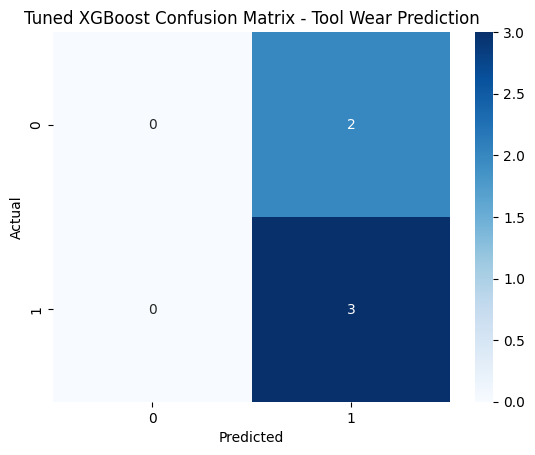


==== Tuned XGBoost: Clamping Fault Prediction ====
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



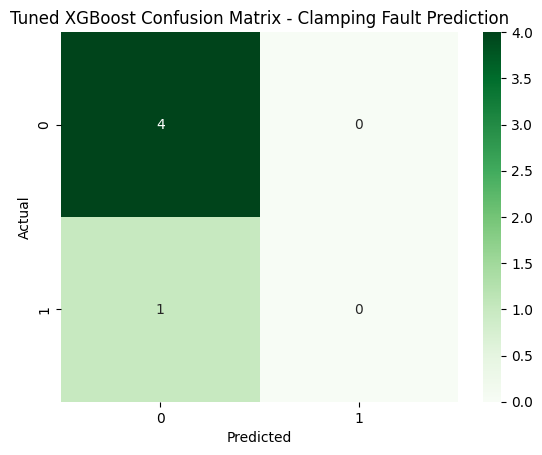

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

from google.colab import files

# Uploading all files: train.csv and experiment_01.xlsx to experiment_18.xlsx
uploaded = files.upload()

# Loading train.csv
train_df = pd.read_csv('train.csv')
train_df['tool_condition'] = train_df['tool_condition'].map({'unworn': 0, 'worn': 1})
train_df['passed_visual_inspection'] = train_df['passed_visual_inspection'].map({'yes': 0, 'no': 1})

# Loading all experiment_XX.xlsx files
experiment_dfs = []
for i in range(1, 19):
    filename = f'experiment_{i:02}.xlsx'
    exp_df = pd.read_excel(filename)
    exp_df['exp_no'] = i
    info = train_df[train_df['No'] == i].iloc[0]
    exp_df['material'] = info['material']
    exp_df['feedrate'] = info['feedrate']
    exp_df['clamp_pressure'] = info['clamp_pressure']
    exp_df['tool_condition'] = info['tool_condition']
    exp_df['machining_finalized'] = info['machining_finalized']
    exp_df['passed_visual_inspection'] = info['passed_visual_inspection']
    experiment_dfs.append(exp_df)

full_df = pd.concat(experiment_dfs, ignore_index=True)

# ========================== FEATURE ENGINEERING ==========================
def extract_features(df):
    features = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        features[f'{col}_mean'] = df[col].mean()
        features[f'{col}_std'] = df[col].std()
        features[f'{col}_rms'] = np.sqrt(np.mean(df[col]**2))
        features[f'{col}_max'] = df[col].max()
        features[f'{col}_min'] = df[col].min()
    return features

feature_list = []
for i in range(1, 19):
    exp_data = full_df[full_df['exp_no'] == i]
    features = extract_features(exp_data)
    features['exp_no'] = i
    features['tool_condition'] = exp_data['tool_condition'].iloc[0]
    features['passed_visual_inspection'] = exp_data['passed_visual_inspection'].iloc[0]
    feature_list.append(features)

features_df = pd.DataFrame(feature_list).dropna()

# ========================== FEATURE SELECTION ==========================
X = features_df.drop(['exp_no', 'tool_condition', 'passed_visual_inspection'], axis=1)
y_tool = features_df['tool_condition']
y_clamp = features_df['passed_visual_inspection']

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y_tool)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]
selected_features = X.columns[indices]

X_tool = features_df[selected_features]
X_clamp = features_df[selected_features]

# ========================== SCALING ==========================
scaler = StandardScaler()
X_tool_scaled = scaler.fit_transform(X_tool)
X_clamp_scaled = scaler.fit_transform(X_clamp)

# ========================== TRAIN TEST SPLIT ==========================
X_train_tool, X_test_tool, y_train_tool, y_test_tool = train_test_split(X_tool_scaled, y_tool, test_size=0.3, random_state=42)
X_train_clamp, X_test_clamp, y_train_clamp, y_test_clamp = train_test_split(X_clamp_scaled, y_clamp, test_size=0.3, random_state=42)

# ========================== HYPERPARAMETER TUNING WITH GRID SEARCH CV ==========================
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1]
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For Tool Wear Prediction
grid_tool = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                         param_grid, cv=kfold, verbose=1, n_jobs=-1)
grid_tool.fit(X_train_tool, y_train_tool)
best_xgb_tool = grid_tool.best_estimator_

# For Clamping Fault Prediction
grid_clamp = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                          param_grid, cv=kfold, verbose=1, n_jobs=-1)
grid_clamp.fit(X_train_clamp, y_train_clamp)
best_xgb_clamp = grid_clamp.best_estimator_

# ========================== FINAL MODEL EVALUATION ==========================

# --- Tool Wear Prediction ---
print("\n==== Tuned XGBoost: Tool Wear Prediction ====")
y_pred_tool = best_xgb_tool.predict(X_test_tool)
print(classification_report(y_test_tool, y_pred_tool))
sns.heatmap(confusion_matrix(y_test_tool, y_pred_tool), annot=True, fmt='d', cmap='Blues')
plt.title("Tuned XGBoost Confusion Matrix - Tool Wear Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Clamping Fault Prediction ---
print("\n==== Tuned XGBoost: Clamping Fault Prediction ====")
y_pred_clamp = best_xgb_clamp.predict(X_test_clamp)
print(classification_report(y_test_clamp, y_pred_clamp))
sns.heatmap(confusion_matrix(y_test_clamp, y_pred_clamp), annot=True, fmt='d', cmap='Greens')
plt.title("Tuned XGBoost Confusion Matrix - Clamping Fault Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
